In [159]:
# Install the tensorflow library
!pip install tensorflow

In [160]:
# Install the sexmachine library
!pip install sexmachine

In [161]:
# Import necessary libraries
import sys
import csv
import os
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import sexmachine.detector as gender
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from  sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc ,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline

In [162]:
def read_datasets():
    """ Reads users profile from csv files """
    genuine_users = pd.read_csv("/content/drive/MyDrive/intern/personal/users.csv")
    fake_users = pd.read_csv("/content/drive/MyDrive/intern/personal/fusers.csv")
    # print genuine_users.columns
    # print genuine_users.describe()
    #print fake_users.describe()
    x=pd.concat([genuine_users,fake_users])
    y=len(fake_users)*[0] + len(genuine_users)*[1]
    return x,y

In [163]:
def predict_sex(name):
    sex_predictor = gender.Detector(unknown_value=u"unknown",case_sensitive=False)
    first_name= name.str.split(' ').str.get(0)
    sex= first_name.apply(sex_predictor.get_gender)
    sex_dict={'female': -2, 'mostly_female': -1,'unknown':0,'mostly_male':1, 'male': 2}
    sex_code = sex.map(sex_dict).astype(int)
    return sex_code


In [164]:
def extract_features(x):
    lang_list = list(enumerate(np.unique(x['lang'])))
    lang_dict = { name : i for i, name in lang_list }
    x.loc[:,'lang_code'] = x['lang'].map( lambda x: lang_dict[x]).astype(int)
    # Removed the line x.loc[:,'sex_code']=predict_sex(x['name']) due to compatibility issues with sexmachine
    feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','lang_code']
    x=x.loc[:,feature_columns_to_use]
    return x

In [165]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    target_names=['Fake','Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [166]:
def plot_roc_curve(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

    print("False Positive rate: ",false_positive_rate)
    print("True Positive rate: ",true_positive_rate)


    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [167]:
print("reading datasets.....\n")
x,y=read_datasets()
x.describe()

reading datasets.....



,id,statuses_count,followers_count,friends_count,favourites_count,listed_count,default_profile,default_profile_image,geo_enabled,profile_use_background_image,profile_background_tile,utc_offset,protected,verified
count,2.818000e+03,2818.000000,2818.000000,2818.000000,2818.000000,2818.000000,1728.0,8.0,721.0,2760.0,489.0,1069.000000,0.0,0.0
mean,5.374889e+08,1672.198368,371.105039,395.363023,234.541164,2.818666,1.0,1.0,1.0,1.0,1.0,1478.391020,NaN,NaN
std,2.977005e+08,4884.669157,8022.631339,465.694322,1445.847248,23.480430,0.0,0.0,0.0,0.0,0.0,8108.211889,NaN,NaN
min,3.610511e+06,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,-39600.000000,NaN,NaN
25%,3.620867e+08,35.000000,17.000000,168.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,3600.000000,NaN,NaN
50%,6.162253e+08,77.000000,26.000000,306.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,3600.000000,NaN,NaN
75%,6.177673e+08,1087.750000,111.000000,519.000000,37.000000,1.000000,1.0,1.0,1.0,1.0,1.0,3600.000000,NaN,NaN
max,1.391998e+09,79876.000000,408372.000000,12773.000000,44349.000000,744.000000,1.0,1.0,1.0,1.0,1.0,36000.000000,NaN,NaN


In [168]:
print("extracting featues.....\n")
x=extract_features(x)
print(x.columns)
print(x.describe())

extracting featues.....

Index(['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'lang_code'],
      dtype='object')
       statuses_count  followers_count  friends_count  favourites_count  \
count     2818.000000      2818.000000    2818.000000       2818.000000   
mean      1672.198368       371.105039     395.363023        234.541164   
std       4884.669157      8022.631339     465.694322       1445.847248   
min          0.000000         0.000000       0.000000          0.000000   
25%         35.000000        17.000000     168.000000          0.000000   
50%         77.000000        26.000000     306.000000          0.000000   
75%       1087.750000       111.000000     519.000000         37.000000   
max      79876.000000    408372.000000   12773.000000      44349.000000   

       listed_count    lang_code  
count   2818.000000  2818.000000  
mean       2.818666     2.851313  
std       23.480430     1.992950  
min        0.000000

In [169]:
x_np = x.values
y_np = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(x_np, y_np, test_size=0.2, random_state=42)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2254, 6)
Shape of X_test: (564, 6)
Shape of y_train: (2254,)
Shape of y_test: (564,)


In [170]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer

model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,561 (10.00 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

In [171]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

In [172]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

In [173]:
feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','lang_code']
x_processed = x[feature_columns_to_use].values.astype(np.float32)
y_np = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(x_processed, y_np, test_size=0.2, random_state=42)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

In [174]:
x,y=read_datasets()
x = extract_features(x)

feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','lang_code']
x_processed = x[feature_columns_to_use].values.astype(np.float32)
y_np = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(x_processed, y_np, test_size=0.2, random_state=42)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

In [175]:
feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','lang_code']
x_processed = x[feature_columns_to_use].values.astype(np.float32)
y_np = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(x_processed, y_np, test_size=0.2, random_state=42)

model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [176]:
# 1. Evaluate the trained model
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

# 2. Make predictions
y_pred_prob = model.predict(X_test)

# 3. Convert probabilities to binary class labels
y_pred_binary = (y_pred_prob > 0.5).astype("int32")

# 4. Calculate and print accuracy score
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"\nAccuracy Score: {accuracy:.4f}")

# 5. Calculate and print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("\nConfusion Matrix:")
print(conf_matrix)

# 6. Calculate and print classification report
class_report = classification_report(y_test, y_pred_binary)
print("\nClassification Report:")
print(class_report)

# 7. Calculate and print AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC Score: {auc_score:.4f}")

Test Loss: 33.3674
Test Accuracy: 0.9131
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Accuracy Score: 0.9131

Confusion Matrix:
[[254  16]
 [ 33 261]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       270
           1       0.94      0.89      0.91       294

    accuracy                           0.91       564
   macro avg       0.91      0.91      0.91       564
weighted avg       0.91      0.91      0.91       564


AUC Score: 0.9229


reading datasets.....

extracting featues.....

training model.....



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


evaluating model.....

Test Loss: 61.4233
Test Accuracy: 0.8954
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Accuracy Score: 0.8954

Confusion Matrix:
[[246  24]
 [ 35 259]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       270
           1       0.92      0.88      0.90       294

    accuracy                           0.90       564
   macro avg       0.90      0.90      0.90       564
weighted avg       0.90      0.90      0.90       564


AUC Score: 0.9035

Plotting confusion matrix and ROC curve.....

False Positive rate:  [0.         0.04444444 0.04444444 0.04444444 0.04444444 0.04444444
 0.04444444 0.04444444 0.04444444 0.04444444 0.04814815 0.04814815
 0.05185185 0.05185185 0.05555556 0.05555556 0.05925926 0.05925926
 0.06296296 0.06296296 0.06666667 0.06666667 0.07037037 0.07037037
 0.08518519 0.08518519 0.09259259 0.09259259 0.0962963  0.0962963
 0.1037037  0.1037037  0.10740741 0.10740741 0.11851852 0

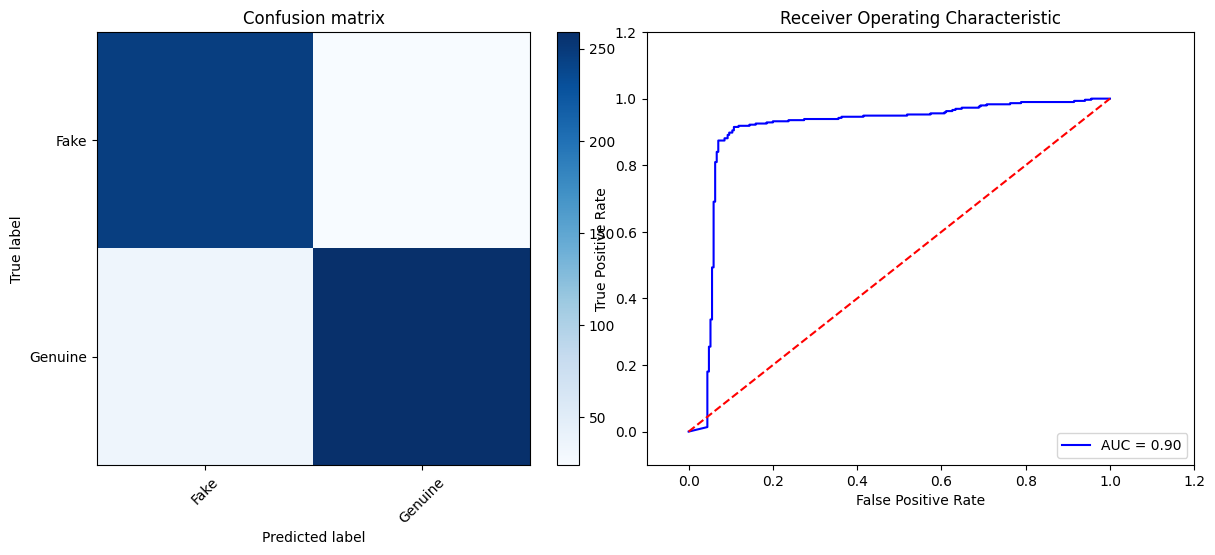

In [177]:
print("reading datasets.....\n")
x,y=read_datasets()

print("extracting featues.....\n")
# Re-apply feature extraction to ensure sex_code and lang_code are present
x = extract_features(x)

# Select features, excluding 'sex_code' due to previous errors
feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','lang_code']
x_processed = x[feature_columns_to_use].values.astype(np.float32)
y_np = np.array(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_processed, y_np, test_size=0.2, random_state=42)

# Define the TensorFlow model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer

model = Sequential()
# Use InputLayer with input_shape
model.add(InputLayer(input_shape=(X_train.shape[1],)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
print("training model.....\n")
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Evaluate the trained model
print("evaluating model.....\n")
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

# Make predictions
y_pred_prob = model.predict(X_test)

# Convert probabilities to binary class labels
y_pred_binary = (y_pred_prob > 0.5).astype("int32")

# Calculate and print metrics
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"\nAccuracy Score: {accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("\nConfusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_pred_binary)
print("\nClassification Report:")
print(class_report)

auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC Score: {auc_score:.4f}")

# Plot confusion matrix and ROC curve
print("\nPlotting confusion matrix and ROC curve.....\n")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_confusion_matrix(conf_matrix)
plt.subplot(1, 2, 2)
plot_roc_curve(y_test, y_pred_prob)
plt.show()

reading datasets.....

extracting featues.....

training model.....

evaluating model.....

Test Loss: 63.4218
Test Accuracy: 0.9184
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Accuracy Score: 0.9184

Confusion Matrix:
[[257  13]
 [ 33 261]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       270
           1       0.95      0.89      0.92       294

    accuracy                           0.92       564
   macro avg       0.92      0.92      0.92       564
weighted avg       0.92      0.92      0.92       564


AUC Score: 0.9285

Plotting confusion matrix and ROC curve.....

False Positive rate:  [0.         0.02222222 0.02222222 0.02222222 0.02222222 0.02222222
 0.02222222 0.02592593 0.02592593 0.02592593 0.02592593 0.02962963
 0.02962963 0.03333333 0.03333333 0.03703704 0.03703704 0.03703704
 0.03703704 0.04814815 0.04814815 0.07037037 0.07037037 0.09259259
 0.09259259 0.0962963  0.0962963  0.1037037  0.1037037

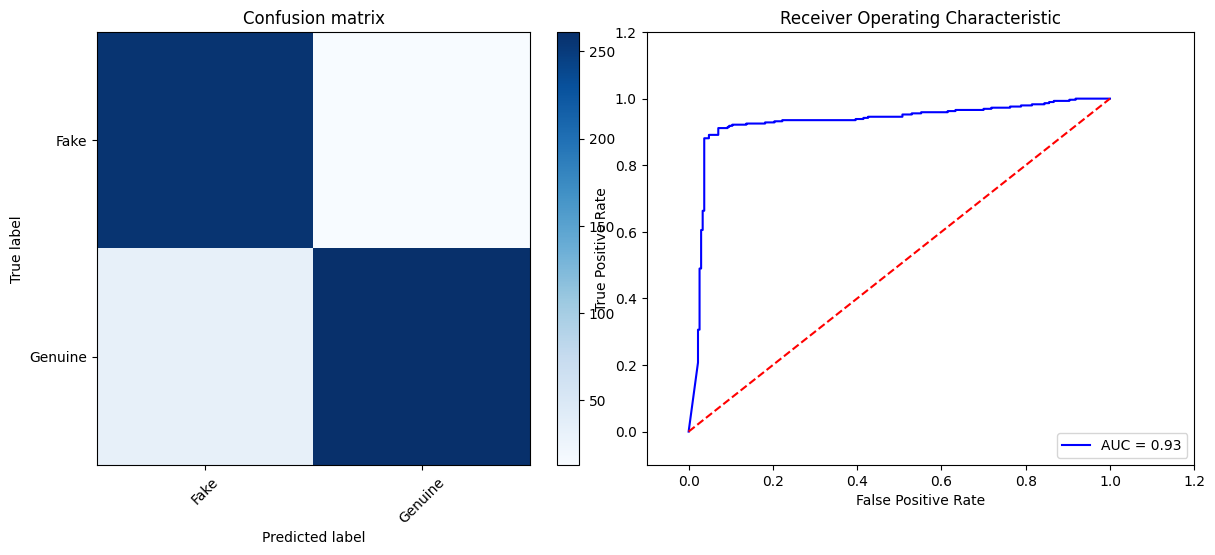

In [178]:
# Modify extract_features to exclude sex_code calculation
def extract_features(x):
    """ Extracts features from the dataframe, excluding sex_code calculation """
    lang_list = list(enumerate(np.unique(x['lang'])))
    lang_dict = { name : i for i, name in lang_list }
    x.loc[:,'lang_code'] = x['lang'].map( lambda x: lang_dict[x]).astype(int)
    # Removed the line x.loc[:,'sex_code']=predict_sex(x['name'])
    feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','lang_code']
    x=x.loc[:,feature_columns_to_use]
    return x

print("reading datasets.....\n")
x,y=read_datasets()

print("extracting featues.....\n")
# Re-apply feature extraction with the modified function
x = extract_features(x)

# Select features (already done in modified extract_features, but kept for clarity)
feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','lang_code']
x_processed = x[feature_columns_to_use].values.astype(np.float32)
y_np = np.array(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_processed, y_np, test_size=0.2, random_state=42)

# Define the TensorFlow model (already defined in previous successful step)
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, InputLayer
# model = Sequential()
# model.add(InputLayer(input_shape=(X_train.shape[1],)))
# model.add(Dense(units=64, activation='relu'))
# model.add(Dense(units=32, activation='relu'))
# model.add(Dense(units=1, activation='sigmoid'))

# Compile the model (already compiled in previous successful step)
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# Train the model
print("training model.....\n")
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Evaluate the trained model
print("evaluating model.....\n")
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

# Make predictions
y_pred_prob = model.predict(X_test)

# Convert probabilities to binary class labels
y_pred_binary = (y_pred_prob > 0.5).astype("int32")

# Calculate and print metrics
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"\nAccuracy Score: {accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("\nConfusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_pred_binary)
print("\nClassification Report:")
print(class_report)

auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC Score: {auc_score:.4f}")

# Plot confusion matrix and ROC curve
print("\nPlotting confusion matrix and ROC curve.....\n")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_confusion_matrix(conf_matrix)
plt.subplot(1, 2, 2)
plot_roc_curve(y_test, y_pred_prob)
plt.show()

In [179]:
# 1. Evaluate the trained model
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

# 2. Make predictions
y_pred_prob = model.predict(X_test)

# 3. Convert probabilities to binary class labels
y_pred_binary = (y_pred_prob > 0.5).astype("int32")

# 4. Calculate and print accuracy score
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"\nAccuracy Score: {accuracy:.4f}")

# 5. Calculate and print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("\nConfusion Matrix:")
print(conf_matrix)

# 6. Calculate and print classification report
class_report = classification_report(y_test, y_pred_binary)
print("\nClassification Report:")
print(class_report)

# 7. Calculate and print AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC Score: {auc_score:.4f}")

Test Loss: 63.4218
Test Accuracy: 0.9184
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Accuracy Score: 0.9184

Confusion Matrix:
[[257  13]
 [ 33 261]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       270
           1       0.95      0.89      0.92       294

    accuracy                           0.92       564
   macro avg       0.92      0.92      0.92       564
weighted avg       0.92      0.92      0.92       564


AUC Score: 0.9285



Plotting confusion matrix and ROC curve.....

False Positive rate:  [0.         0.02222222 0.02222222 0.02222222 0.02222222 0.02222222
 0.02222222 0.02592593 0.02592593 0.02592593 0.02592593 0.02962963
 0.02962963 0.03333333 0.03333333 0.03703704 0.03703704 0.03703704
 0.03703704 0.04814815 0.04814815 0.07037037 0.07037037 0.09259259
 0.09259259 0.0962963  0.0962963  0.1037037  0.1037037  0.13703704
 0.13703704 0.18148148 0.18148148 0.2037037  0.2037037  0.22222222
 0.22222222 0.3962963  0.3962963  0.41481481 0.41481481 0.42592593
 0.42592593 0.50740741 0.50740741 0.52962963 0.52962963 0.55185185
 0.55185185 0.61481481 0.61481481 0.63333333 0.63333333 0.7
 0.7        0.71851852 0.71851852 0.76296296 0.76296296 0.78888889
 0.78888889 0.81481481 0.81481481 0.84444444 0.84444444 0.85555556
 0.85555556 0.86666667 0.86666667 0.9037037  0.9037037  0.91851852
 0.91851852 1.        ]
True Positive rate:  [0.         0.20748299 0.24829932 0.2585034  0.26870748 0.28231293
 0.30612245 0.30612245

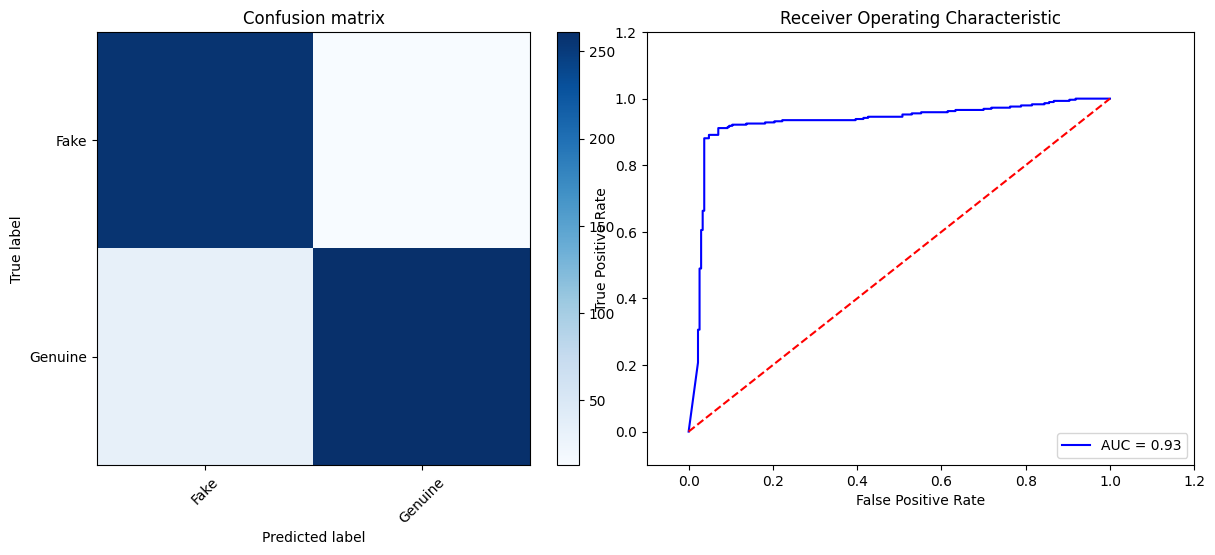

In [180]:
# Plot confusion matrix and ROC curve
print("\nPlotting confusion matrix and ROC curve.....\n")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_confusion_matrix(conf_matrix)
plt.subplot(1, 2, 2)
plot_roc_curve(y_test, y_pred_prob)
plt.show()